In [67]:
"""Exploring the relationship between variables."""

'Exploring the relationship between variables.'

# Исследование отношения между переменными

*Elements of Data Science*, copyright 2021 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

В этой главе исследуются отношения между переменными.

* Мы будем визуализировать отношения с помощью *диаграмм рассеяния* (scatter plots), *диаграмм размаха* (box plots) и *скрипичных диаграмм* (violin plots),

* И мы будем количественно определять отношения, используя *корреляцию* (correlation) и *простую регрессию* (simple regression).

Самый важный урок этой главы заключается в том, что вы всегда должны визуализировать взаимосвязь между переменными, прежде чем пытаться ее количественно оценить; в противном случае вас могут ввести в заблуждение.

In [68]:
from os.path import basename, exists
from urllib.request import urlretrieve

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# CDF веса
from empiricaldist import Cdf, Pmf

# Сравнение с нормальным распределением
from scipy.stats import linregress, norm


def download(url: str) -> None:
    """Загружает файл по URL, если его нет локально."""
    filename: str = basename(url)
    if not exists(filename):
        local, _ = urlretrieve(url, filename)
        print("Скачано: " + local)


download(
    "https://github.com/AllenDowney/" + "ElementsOfDataScience/raw/master/brfss.hdf5"
)

## Изучение отношений

В качестве первого примера мы рассмотрим взаимосвязь между ростом и весом.

Мы будем использовать данные из *Системы наблюдения за поведенческими факторами риска* (BRFSS), которая находится в ведении *Центров по контролю за заболеваниями* по адресу <https://www.cdc.gov/brfss>.

В опросе приняли участие более 400 000 респондентов, но, чтобы произвести анализ, я выбрал случайную подвыборку из 100 000 человек.

In [69]:
brfss = pd.read_hdf("brfss.hdf5", "brfss")
brfss.shape

(100000, 9)

Вот несколько строк:

In [70]:
brfss.head()

,SEX,HTM4,WTKG3,INCOME2,_LLCPWT,_AGEG5YR,_VEGESU1,_HTMG10,AGE
96230,2.0,160.0,60.33,8.0,1398.525290,6.0,2.14,150.0,47.0
244920,2.0,163.0,58.97,5.0,84.057503,13.0,3.14,160.0,89.5
57312,2.0,163.0,72.57,8.0,390.248599,5.0,2.64,160.0,42.0
32573,2.0,165.0,74.84,1.0,11566.705300,3.0,1.46,160.0,32.0
355929,2.0,170.0,108.86,3.0,844.485450,3.0,1.81,160.0,32.0


BRFSS включает сотни переменных. Для примеров в этой главе я выбрал всего девять.

Мы начнем с `HTM4`, который записывает рост каждого респондента в см, и `WTKG3`, который записывает вес в кг.

In [71]:
height = brfss["HTM4"]
weight = brfss["WTKG3"]

Чтобы визуализировать взаимосвязь между этими переменными, мы построим **диаграмму рассеяния** (scatter plot).

Диаграммы рассеяния широко распространены и понятны, но их на удивление сложно правильно построить.

В качестве первой попытки мы будем использовать функцию `plot` с аргументом `o`, который строит круг для каждой точки.

> см. [документацию по plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html)

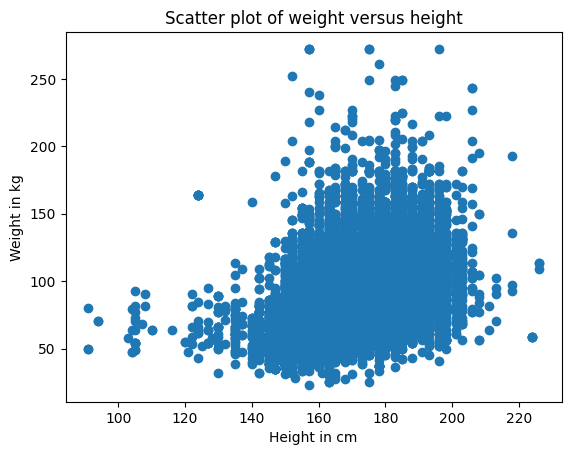

In [72]:
%matplotlib inline

plt.plot(height, weight, "o")

plt.xlabel("Height in cm")
plt.ylabel("Weight in kg")
plt.title("Scatter plot of weight versus height");

Похоже, что высокие люди тяжелее, но в этом графике есть несколько моментов, которые затрудняют интерпретацию.

Первый из них - **перекрытие** (overplotted), то есть точки данных накладываются друг на друга, поэтому вы не можете сказать, где много точек, а где только одна.

Когда это происходит, результаты могут вводить в заблуждение.

Один из способов улучшить график - использовать *прозрачность* (transparency), что мы можем сделать с помощью ключевого аргумента `alpha`. Чем ниже значение `alpha`, тем прозрачнее каждая точка данных.

Вот как это выглядит с `alpha=0.02`.

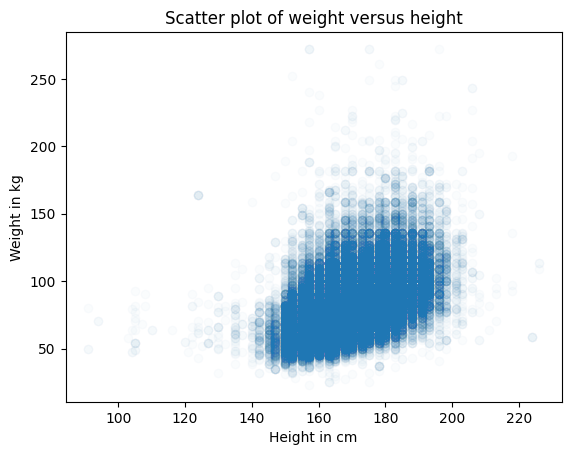

In [73]:
plt.plot(height, weight, "o", alpha=0.02)

plt.xlabel("Height in cm")
plt.ylabel("Weight in kg")
plt.title("Scatter plot of weight versus height");

Уже лучше, но на графике так много точек данных, что диаграмма рассеяния все еще перекрывается. Следующим шагом будет уменьшение размеров маркеров.

При `markersize=1` и низком значении `alpha` диаграмма рассеяния будет менее насыщенной.

Вот как это выглядит.

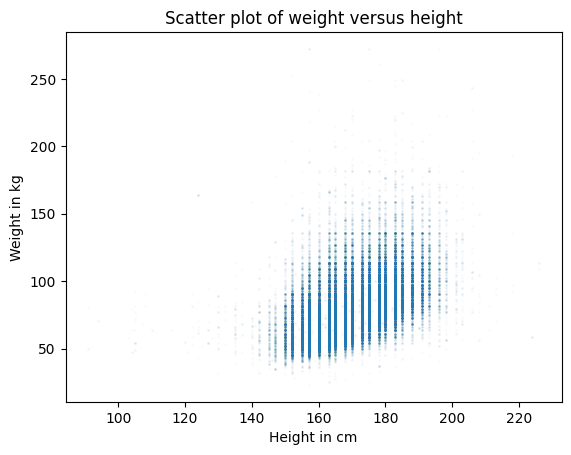

In [74]:
plt.plot(height, weight, "o", alpha=0.02, markersize=1)

plt.xlabel("Height in cm")
plt.ylabel("Weight in kg")
plt.title("Scatter plot of weight versus height");

Уже лучше, но теперь мы видим, что точки строятся отдельными столбцами. Это потому, что большая часть высоты была указана в дюймах и преобразована в сантиметры.

Мы можем разбить столбцы, *добавив к значениям некоторый случайный шум*; по сути, мы заполняем округленные значения.

Такое добавление случайного шума называется **дрожанием** (jittering).

> *Дрожание* - это добавление случайного шума к данным для предотвращения перекрытия статистических графиков. Если непрерывное измерение округлено до некоторой удобной единицы, может произойти перекрытие. Это приводит к превращению непрерывной переменной в дискретную порядковую переменную. Например, возраст измеряется в годах, а масса тела - в фунтах или килограммах. Если вы построите диаграмму разброса веса в зависимости от возраста для достаточно большой выборки людей, там может быть много людей, записанных, скажем, с 29 годами и 70 кг, и, следовательно, в этой точке будет нанесено много маркеров (29, 70).

> Чтобы уменьшить перекрытие, вы можете добавить к данным небольшой случайный шум. Размер шума часто выбирается равным ширине единицы измерения. Например, к значению 70 кг вы можете добавить количество *u* , где *u* - равномерная случайная величина в интервале [-0,5, 0,5]. Вы можете обосновать дрожание, предположив, что истинный вес человека весом 70 кг с равной вероятностью находится в любом месте интервала [69,5, 70,5].

> Контекст данных важен при принятии решения о дрожании. Например, возраст обычно округляется в меньшую сторону: 29-летний человек может праздновать свой 29-й день рождения сегодня или, возможно, ему исполнится 30 завтра, но ей все равно 29 лет. Следовательно, вы можете изменить возраст, добавив величину *v* , где *v* - равномерная случайная величина в интервале [0,1]. (Мы игнорируем статистически значимый случай женщин, которым остается 29 лет в течение многих лет!)

> *Источник*: [Jittering to prevent overplotting in statistical graphics](https://blogs.sas.com/content/iml/2011/07/05/jittering-to-prevent-overplotting-in-statistical-graphics.html)

Мы можем использовать NumPy для добавления шума из нормального распределения со средним 0 и стандартным отклонением 2.

> см. [документацию NumPy](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html)

In [75]:
noise = np.random.normal(0, 2, size=len(brfss))
height_jitter = height + noise

Вот как выглядит график с дрожащими (jittered) высотами.

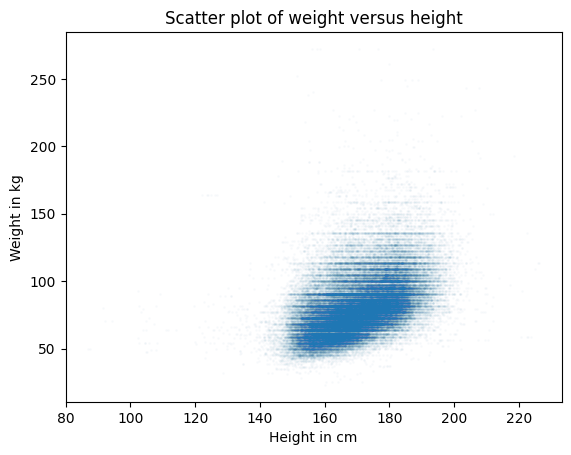

In [76]:
plt.plot(height_jitter, weight, "o", alpha=0.02, markersize=1)

plt.xlabel("Height in cm")
plt.ylabel("Weight in kg")
plt.title("Scatter plot of weight versus height");

Столбцы исчезли, но теперь мы видим, что есть строки, в которых люди округляют свой вес. Мы также можем исправить это с помощью дрожания веса.

In [77]:
noise = np.random.normal(0, 2, size=len(brfss))
weight_jitter = weight + noise

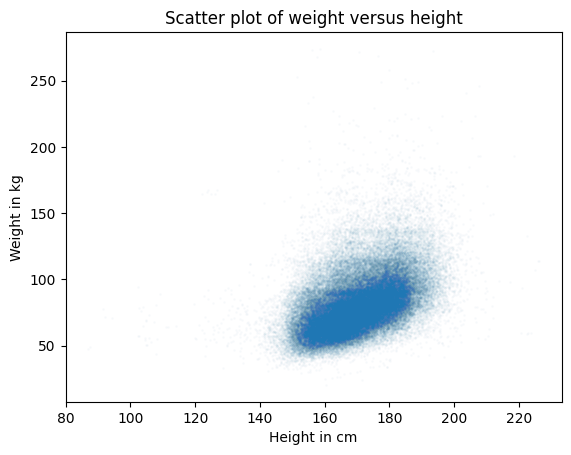

In [78]:
plt.plot(height_jitter, weight_jitter, "o", alpha=0.02, markersize=1)

plt.xlabel("Height in cm")
plt.ylabel("Weight in kg")
plt.title("Scatter plot of weight versus height");

Наконец, давайте увеличим масштаб области, где находится большинство точек данных.

Функции `xlim` и `ylim` устанавливают нижнюю и верхнюю границы для осей $x$ и $y$; в данном случае мы наносим рост от 140 до 200 сантиметров и вес до 160 килограмм.

Вот как это выглядит.

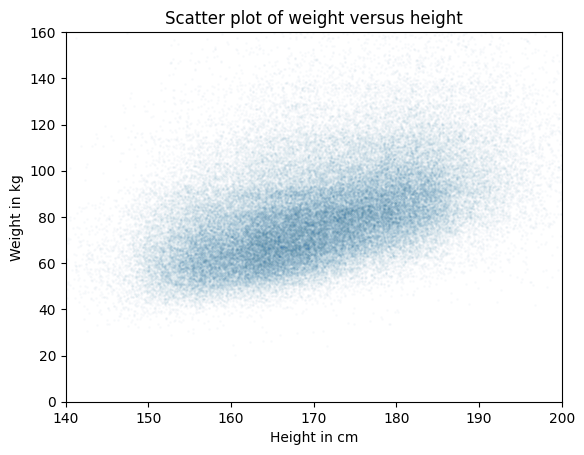

In [79]:
plt.plot(height_jitter, weight_jitter, "o", alpha=0.02, markersize=1)

plt.xlim([140, 200])
plt.ylim([0, 160])
plt.xlabel("Height in cm")
plt.ylabel("Weight in kg")
plt.title("Scatter plot of weight versus height");

Теперь у нас есть достоверная картина взаимосвязи между ростом и весом.

Ниже вы можете увидеть вводящий в заблуждение график, с которого мы начали, и более надежный, которым мы закончили. Они явно разные, и они предлагают разные истории о взаимосвязи между этими переменными.

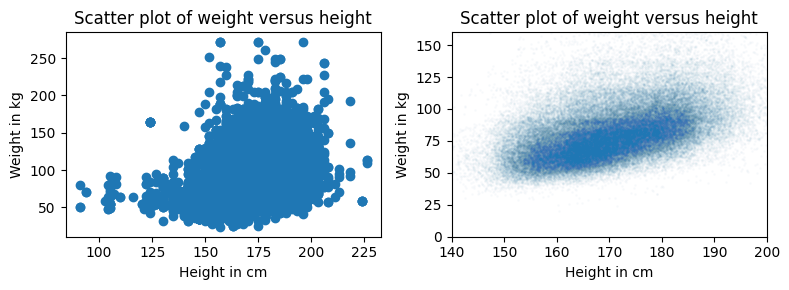

In [80]:
# Set the figure size
plt.figure(figsize=(8, 3))

# Create subplots with 2 rows, 1 column, and start plot 1
plt.subplot(1, 2, 1)
plt.plot(height, weight, "o")

plt.xlabel("Height in cm")
plt.ylabel("Weight in kg")
plt.title("Scatter plot of weight versus height")

# Adjust the layout so the two plots don't overlap
plt.tight_layout()

# Start plot 2
plt.subplot(1, 2, 2)

plt.plot(height_jitter, weight_jitter, "o", alpha=0.02, markersize=1)

plt.xlim([140, 200])
plt.ylim([0, 160])
plt.xlabel("Height in cm")
plt.ylabel("Weight in kg")
plt.title("Scatter plot of weight versus height")
plt.tight_layout()

Смысл этого примера в том, что для создания эффективного графика разброса требуются некоторые усилия.

**Упражнение №1** Набирают ли люди вес с возрастом? Мы можем ответить на этот вопрос, визуализировав взаимосвязь между весом и возрастом.

Но прежде чем строить диаграмму рассеяния, рекомендуется визуализировать распределения по одной переменной за раз. Итак, давайте посмотрим на возрастное распределение.

Набор данных BRFSS включает столбец `AGE`, который представляет возраст каждого респондента в годах. Чтобы защитить конфиденциальность респондентов, возраст округляется до пятилетних интервалов. `AGE` содержит середину интервалов (bins).

- Извлеките переменную `'AGE'` из фрейма данных `brfss` и присвойте ее `age`.

- Постройте [функцию вероятности](https://ru.wikipedia.org/wiki/%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F_%D0%B2%D0%B5%D1%80%D0%BE%D1%8F%D1%82%D0%BD%D0%BE%D1%81%D1%82%D0%B8) (Probability mass function, PMF) для `age` в виде гистограммы, используя `Pmf` из `empiricaldist`.

> [`empiricaldist`](https://nbviewer.jupyter.org/github/AllenDowney/empiricaldist/blob/master/empiricaldist/dist_demo.ipynb) - библиотека Python, представляющая эмпирические функции распределения.

In [81]:
# try:
#     import empiricaldist
# except ImportError:
#     !pip install empiricaldist

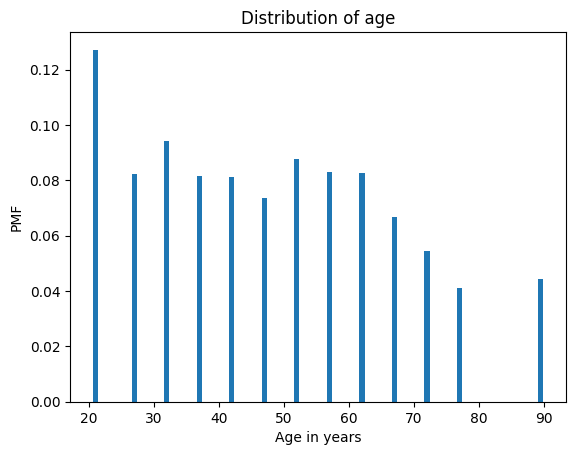

In [82]:
age = brfss["AGE"]
pmf_age = Pmf.from_seq(age)
pmf_age.bar()

plt.xlabel("Age in years")
plt.ylabel("PMF")
plt.title("Distribution of age")
plt.show()

**Упражнение №2:** Теперь давайте посмотрим на распределение веса.

Столбец, содержащий вес в килограммах, - это `WTKG3`. Поскольку этот столбец содержит много уникальных значений, отображение его как функции вероятности (PMF) работает плохо.

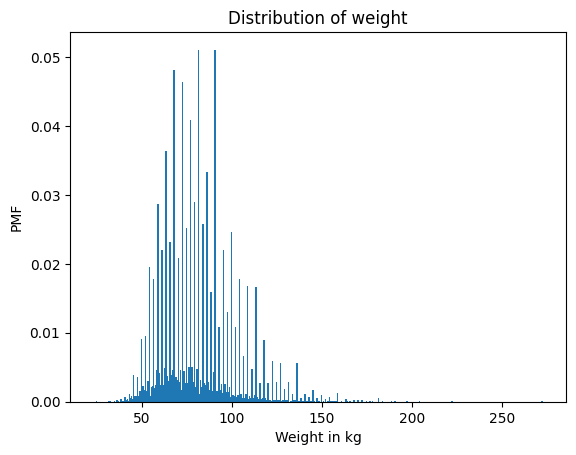

In [83]:
Pmf.from_seq(weight).bar()

plt.xlabel("Weight in kg")
plt.ylabel("PMF")
plt.title("Distribution of weight");

Чтобы получить лучшее представление об этом распределении, попробуйте построить график [функции распределения](https://ru.wikipedia.org/wiki/%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F) (Cumulative distribution function, CDF).

Вычислите функцию распределения (CDF) нормального распределения с тем же средним значением и стандартным отклонением и сравните его с распределением веса.

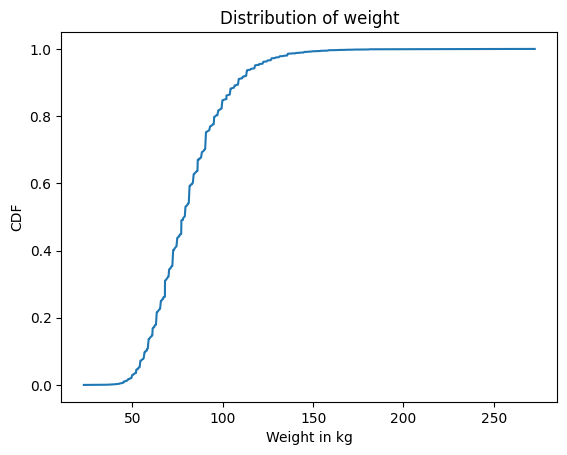

In [84]:
cdf_weight = Cdf.from_seq(weight)
cdf_weight.plot()
plt.xlabel("Weight in kg")
plt.ylabel("CDF")
plt.title("Distribution of weight")
plt.show()

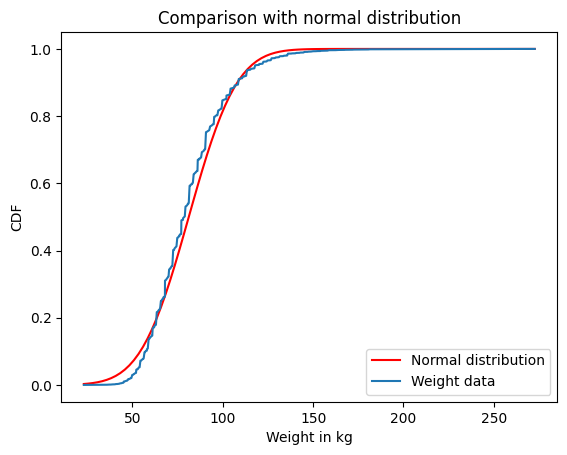

In [85]:
mu, std = weight.mean(), weight.std()
xs = np.linspace(weight.min(), weight.max(), 100)
ys = norm.cdf(xs, mu, std)

plt.plot(xs, ys, color="red", label="Normal distribution")
cdf_weight.plot(label="Weight data")
plt.xlabel("Weight in kg")
plt.ylabel("CDF")
plt.legend()
plt.title("Comparison with normal distribution")
plt.show()

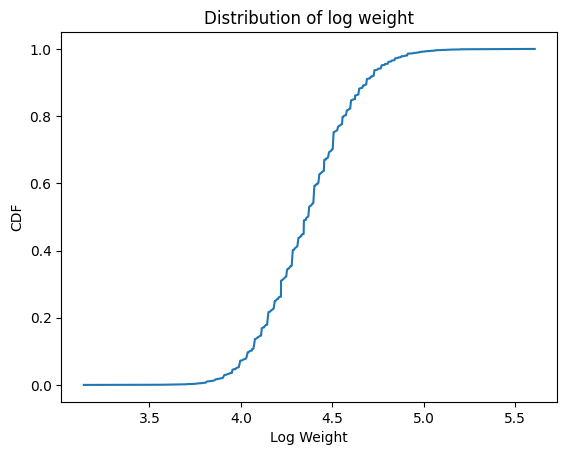

In [86]:
# Логарифмическое преобразование
log_weight = np.log(weight)  # type: ignore
cdf_log_weight = Cdf.from_seq(log_weight)
cdf_log_weight.plot()
plt.xlabel("Log Weight")
plt.ylabel("CDF")
plt.title("Distribution of log weight")
plt.show()

Подходит ли нормальное распределение для этих данных? А как насчет логарифмического преобразования весов?

Ответ: НЕТ, распределение веса имеет правый (положительный) скос и не соответствует нормальному распределению. Логарифмическое преобразование улучшает ситуацию, но не делает распределение полностью нормальным.

**Упражнение №3:** Теперь давайте построим диаграмму разброса (scatter plot) для `weight` и `age`.

Отрегулируйте `alpha` и `markersize`, чтобы избежать наложения (overplotting). Используйте `ylim`, чтобы ограничить ось `y` от 0 до 200 килограммов.

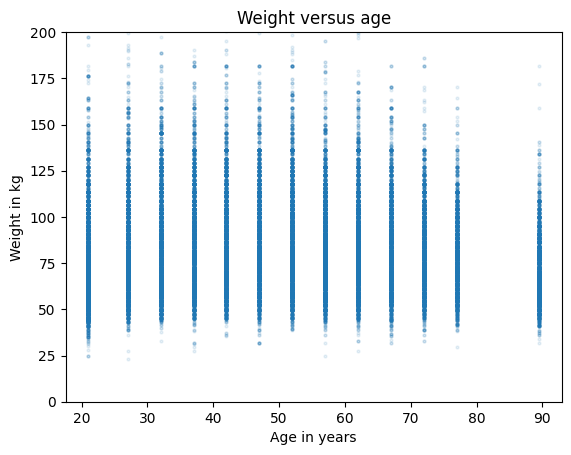

In [87]:
age = brfss["AGE"]
weight = brfss["WTKG3"]

plt.plot(age, weight, "o", alpha=0.1, markersize=2)
plt.xlabel("Age in years")
plt.ylabel("Weight in kg")
plt.ylim([0, 200])
plt.title("Weight versus age")
plt.show()

**Упражнение №4:** В предыдущем упражнении возрасты указаны в столбцах, потому что они были округлены до 5-летних интервалов (bins). Если мы добавим дрожание (jitter), диаграмма рассеяния покажет взаимосвязь более четко.

- Добавьте случайный шум к `age` со средним значением `0` и стандартным отклонением `2.5`.
- Создайте диаграмму рассеяния и снова отрегулируйте `alpha` и `markersize`.

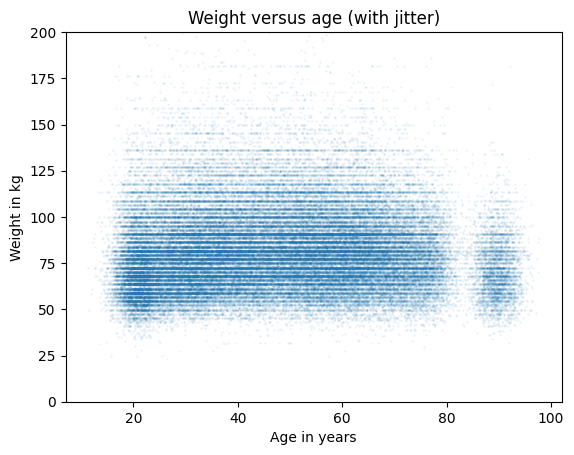

In [88]:
noise = np.random.normal(0, 2.5, size=len(brfss))
age_jitter = age + noise

plt.plot(age_jitter, weight, "o", alpha=0.05, markersize=1)
plt.xlabel("Age in years")
plt.ylabel("Weight in kg")
plt.ylim([0, 200])
plt.title("Weight versus age (with jitter)")
plt.show()

## Визуализация отношений

В предыдущем разделе мы использовали диаграммы разброса для визуализации взаимосвязей между переменными, а в упражнениях вы исследовали взаимосвязь между возрастом и весом. В этом разделе мы увидим другие способы визуализации этих отношений, в том числе диаграммы размаха и скрипичные диаграммы.

Я начну с диаграммы разброса веса в зависимости от возраста.

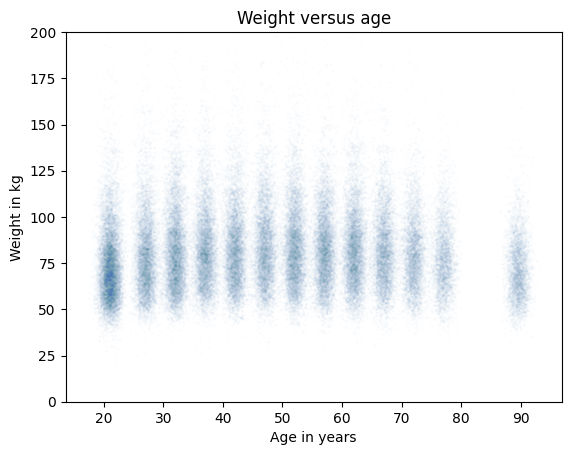

In [89]:
age = brfss["AGE"]
noise = np.random.normal(0, 1.0, size=len(brfss))
age_jitter = age + noise

plt.plot(age_jitter, weight_jitter, "o", alpha=0.01, markersize=1)

plt.xlabel("Age in years")
plt.ylabel("Weight in kg")
plt.ylim([0, 200])
plt.title("Weight versus age");

В этой версии диаграммы разброса я скорректировал дрожание весов, чтобы между столбцами оставалось пространство.

Это позволяет увидеть форму распределения в каждой возрастной группе и различия между группами.

С этой точки зрения кажется, что вес увеличивается до 40-50 лет, а затем начинает уменьшаться.

Если мы пойдем дальше, то сможем использовать [ядерную оценку плотности](https://ru.wikipedia.org/wiki/%D0%AF%D0%B4%D0%B5%D1%80%D0%BD%D0%B0%D1%8F_%D0%BE%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BF%D0%BB%D0%BE%D1%82%D0%BD%D0%BE%D1%81%D1%82%D0%B8) (Kernel Density Estimation, KDE) для оценки функции плотности в каждом столбце и построения графика. И для этого есть название - **скрипичная диаграмма** (violin plot).

Библиотека Seaborn предоставляет функцию, которая создает скрипичную диаграмму, но прежде чем мы сможем ее использовать, мы должны избавиться от любых строк с пропущенными данными.

Вот так:

In [90]:
data = brfss.dropna(subset=["AGE", "WTKG3"])  # type: ignore[call-overload]
data.shape

(92729, 9)

`dropna()` создает новый фрейм данных, который удаляет строки из `brfss`, где `AGE` или `WTKG3` равны `NaN`.

Теперь мы можем вызвать функцию `violinplot`.

> см. [документацию по violinplot](https://seaborn.pydata.org/generated/seaborn.violinplot.html)

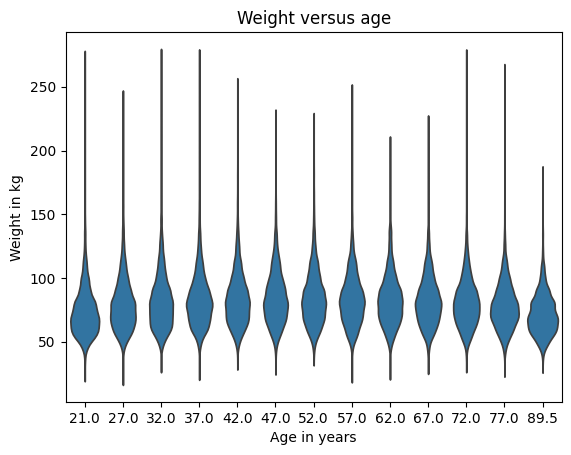

In [91]:
sns.violinplot(x="AGE", y="WTKG3", data=data, inner=None)

plt.xlabel("Age in years")
plt.ylabel("Weight in kg")
plt.title("Weight versus age");

Аргументы `x` и `y` означают, что нам нужно `AGE` на оси x и `WTKG3` на оси y.

`data` - это только что созданный фрейм данных, который содержит переменные для отображения.

Аргумент `inner=None` немного упрощает график.

На рисунке каждая фигура представляет собой распределение веса в одной возрастной группе. Ширина этих форм пропорциональна предполагаемой плотности, так что это похоже на две вертикальные ядерные оценки плотности (KDE), построенные вплотную друг к другу (и залитые красивыми цветами).

Другой, связанный с этим способ просмотра данных, называется **диаграмма размаха** (ящик с усами, box plot).

Код для создания диаграммы размаха очень похож.

> см. [документацию по boxplot](https://seaborn.pydata.org/generated/seaborn.boxplot.html)

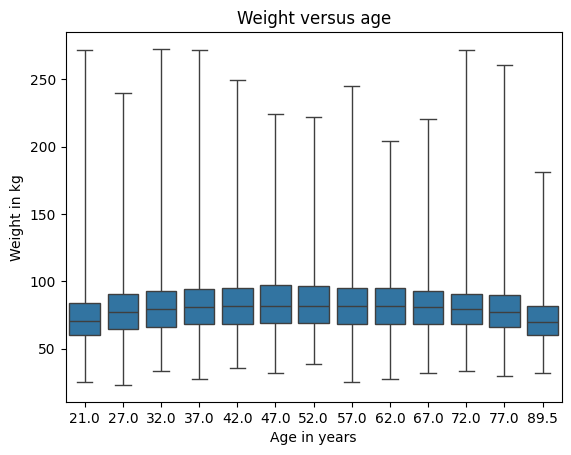

In [92]:
sns.boxplot(x="AGE", y="WTKG3", data=data, whis=10)

plt.xlabel("Age in years")
plt.ylabel("Weight in kg")
plt.title("Weight versus age");

Я включил аргумент `whis=10`, чтобы отключить функцию, которая нам не нужна.

Каждый прямоугольник представляет распределение веса в возрастной группе. Высота каждого прямоугольника представляет собой диапазон от 25-го до 75-го процентиля. Линия в середине каждого прямоугольника - это медиана. Шипы, торчащие сверху и снизу, показывают минимальное и максимальное значения.

На мой взгляд, этот график дает лучшее представление о взаимосвязи между весом и возрастом.

* Глядя на медианы, кажется, что люди в возрасте от 40 лет являются самыми тяжелыми; люди младшего и старшего возраста легче.

* Глядя на размеры ящиков, кажется, что люди в возрасте от 40 также имеют наибольший разброс в весе.

* Эти графики также показывают, насколько искажено распределение веса; то есть самые тяжелые люди намного дальше от медианы, чем самые легкие.

Для данных, которые склоняются к более высоким значениям, иногда полезно рассматривать их в логарифмической шкале.

Мы можем сделать это с помощью Pyplot-функции `yscale`.

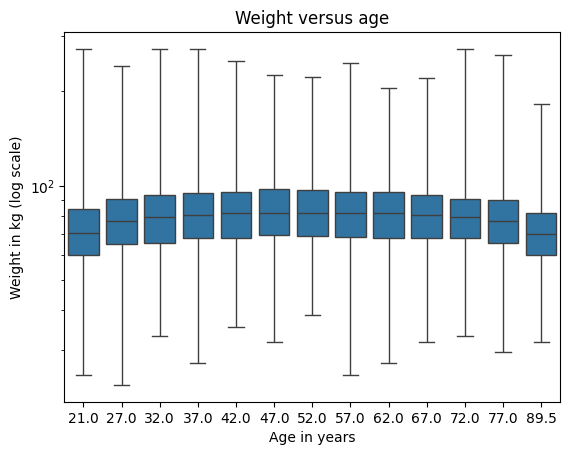

In [93]:
sns.boxplot(x="AGE", y="WTKG3", data=data, whis=10)

plt.yscale("log")
plt.xlabel("Age in years")
plt.ylabel("Weight in kg (log scale)")
plt.title("Weight versus age");

Чтобы наиболее четко показать взаимосвязь между возрастом и весом, я бы использовал этот рисунок.

В следующих упражнениях у вас будет возможность создать скрипичную диаграмму и диаграмму размаха.

**Упражнение №5:** Ранее мы рассмотрели диаграмму рассеяния (scatter plot) по росту и весу и увидели, что более высокие люди, как правило, тяжелее. Теперь давайте более подробно рассмотрим диаграмму размаха (box plot).

Фрейм данных `brfss` содержит столбец с именем `_HTMG10`, который представляет высоту в сантиметрах, разбитую на группы по 10 см.

- Составьте диаграмму размаха, показывающую распределение веса в каждой группе роста.

- Постройте ось Y в логарифмическом масштабе.

*Предложение*: если метки на оси `x` сталкиваются, вы можете повернуть их следующим образом:

```
plt.xticks(rotation='45')
```

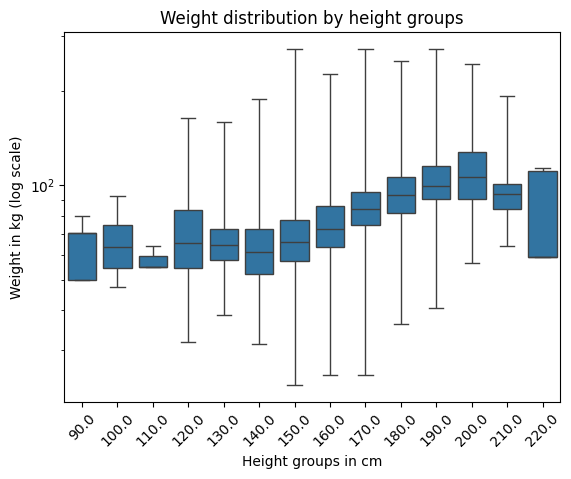

In [94]:
brfss = brfss.reset_index(drop=True)
# принудительно уникальный индекс
# brfss.index = range(len(brfss))

sns.boxplot(x="_HTMG10", y="WTKG3", data=brfss, whis=10)
plt.yscale("log")

plt.setp(plt.gca().get_xticklabels(), rotation=45)

plt.xlabel("Height groups in cm")
plt.ylabel("Weight in kg (log scale)")
plt.title("Weight distribution by height groups")
plt.show()

**Упражнение №6:** В качестве второго примера давайте посмотрим на взаимосвязь между доходом (income) и ростом.

В BRFSS доход представлен как категориальная переменная; то есть респондентов относят к одной из 8 категорий доходов. Имя столбца - `INCOME2`.

Прежде чем связывать доход с чем-либо еще, давайте посмотрим на распределение, вычислив функцию вероятности (PMF).

* Извлеките `INCOME2` из `brfss` и присвойте его `income`.

* Постройте функцию вероятности (PMF) для `income` в виде гистограммы (bar chart).

*Примечание*: вы увидите, что около трети респондентов относятся к группе с самым высоким доходом; лучше, если бы было больше лидирующих групп, но мы будем работать с тем, что у нас есть.

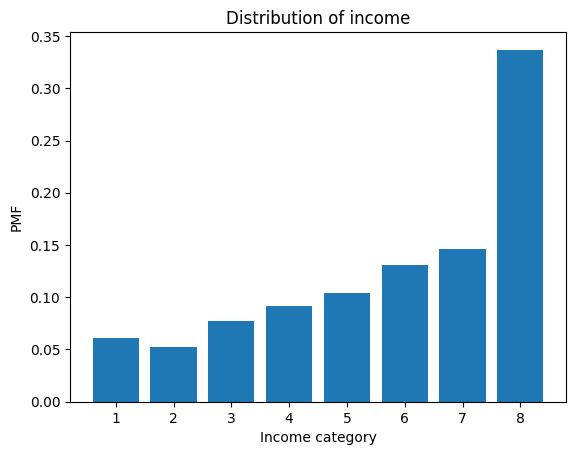

In [95]:
income = brfss["INCOME2"]
pmf_income = Pmf.from_seq(income)
pmf_income.bar()

plt.xlabel("Income category")
plt.ylabel("PMF")
plt.title("Distribution of income")
plt.show()

**Упражнение №7:** Создайте скрипичную диаграмму (violin plot), которая показывает распределение роста в каждой группе дохода.

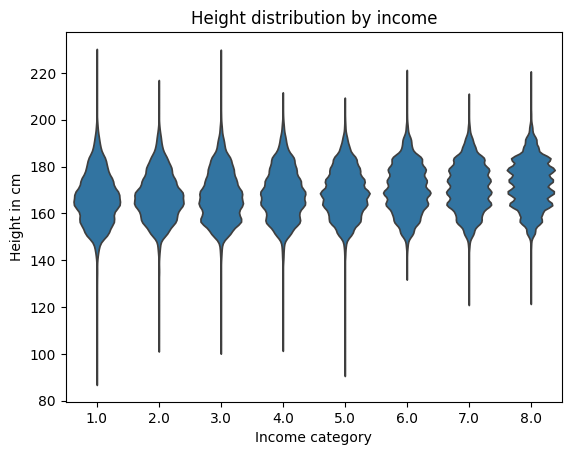

In [96]:
data = brfss.dropna(subset=["INCOME2", "HTM4"])  # type: ignore[call-overload]
sns.violinplot(x="INCOME2", y="HTM4", data=data, inner=None)
plt.xlabel("Income category")
plt.ylabel("Height in cm")
plt.title("Height distribution by income")
plt.show()

Вы видите взаимосвязь между этими переменными?

Ответ: СЛАБАЯ ЗАВИСИМОСТЬ. Люди с более высоким доходом имеют несколько больший средний рост, но разница незначительная.

## Корреляция

В предыдущем разделе мы визуализировали отношения между парами переменных. Теперь мы узнаем о **коэффициенте корреляции**, который количественно определяет силу этих взаимосвязей.

Когда люди говорят "корреляция", они имеют в виду любую связь между двумя переменными. В статистике обычно это означает коэффициент корреляции [Пирсона](https://ru.wikipedia.org/wiki/%D0%9F%D0%B8%D1%80%D1%81%D0%BE%D0%BD,_%D0%9A%D0%B0%D1%80%D0%BB), который представляет собой число от `-1` до `1`, которое количественно определяет силу линейной связи между переменными.

Для демонстрации я выберу три столбца из набора данных BRFSS:

In [97]:
columns = ["HTM4", "WTKG3", "AGE"]
subset = brfss[columns]

Результатом является фрейм данных только с этими столбцами.

С этим подмножеством данных мы можем использовать метод [`corr`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html), например:

In [98]:
subset.corr()  # type: ignore[call-arg]

,HTM4,WTKG3,AGE
HTM4,1.000000,0.474203,-0.093684
WTKG3,0.474203,1.000000,0.021641
AGE,-0.093684,0.021641,1.000000


Результатом является **корреляционная матрица**. В первой строке корреляция `HTM4` с самим собой равна `1`. Это ожидаемо; корреляция чего-либо с самим собой равна `1`.

Следующая запись более интересна; соотношение роста и веса составляет около `0.47`. Коэффициент положительный, это означает, что более высокие люди тяжелее, и он умеренный по силе, что означает, что он имеет некоторую прогностическую ценность. Если вы знаете чей-то рост, вы можете лучше предположить его вес, и наоборот.

Корреляция между ростом и возрастом составляет примерно `-0.09`. Коэффициент отрицательный, это означает, что пожилые люди, как правило, ниже ростом, но он слабый, а это означает, что знание чьего-либо возраста не поможет, если вы попытаетесь угадать их рост.

Корреляция между возрастом и весом еще меньше. Напрашивается вывод, что нет никакой связи между возрастом и весом, но мы уже видели, что она есть. Так почему же корреляция такая низкая?

Помните, что зависимость между весом и возрастом выглядит так.

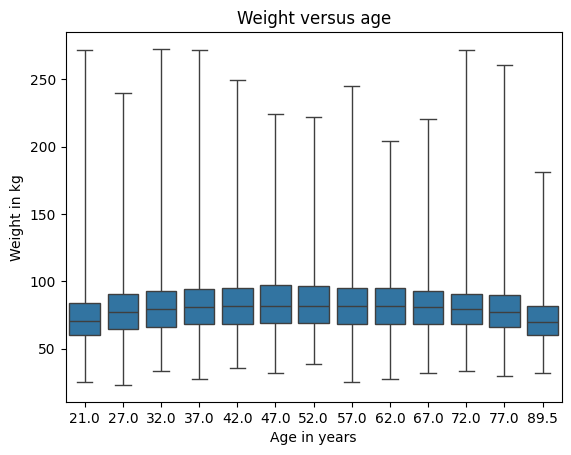

In [99]:
data = brfss.dropna(subset=["AGE", "WTKG3"])  # type: ignore[call-overload]
sns.boxplot(x="AGE", y="WTKG3", data=data, whis=10)

plt.xlabel("Age in years")
plt.ylabel("Weight in kg")
plt.title("Weight versus age");

Люди за сорок - самые тяжелые; люди младшего и старшего возраста легче. Итак, эта связь нелинейна.

Но корреляция измеряет только линейные отношения. Если связь нелинейная, корреляция обычно недооценивает ее силу.

Чтобы продемонстрировать, я сгенерирую несколько поддельных данных: `xs` содержит точки с равным интервалом между `-1` и `1`.

`ys` - это квадрат `xs` плюс некоторый случайный шум.

In [100]:
xs = np.linspace(-1, 1)
ys = xs**2 + np.random.normal(0, 0.05, len(xs))

Вот диаграмма рассеяния для `xs` и `ys`.

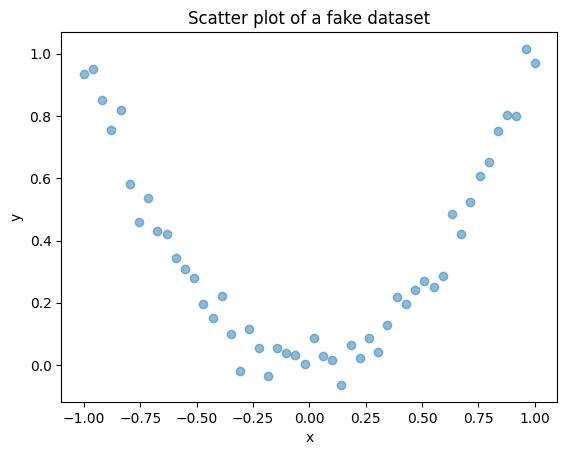

In [101]:
plt.plot(xs, ys, "o", alpha=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Scatter plot of a fake dataset");

Понятно, что это сильная связь; если вам дано `x`, вы можете гораздо лучше догадаться о `y`.

Но вот корреляционная матрица:

In [102]:
np.corrcoef(xs, ys)

array([[1.        , 0.02259408],
       [0.02259408, 1.        ]])

Несмотря на то, что существует сильная нелинейная зависимость, вычисленная корреляция близка к `0`.

> В общем, если корреляция высока, то есть близка к `1` или `-1`, вы можете сделать вывод, что существует сильная линейная зависимость.
Но если корреляция близка к `0`, это не означает, что связи нет; может быть связь нелинейная.

Это одна из причин, по которой я считаю, что корреляция не является хорошей статистикой.

В частности, корреляция ничего не говорит о наклоне. Если мы говорим, что две переменные коррелируют, это означает, что мы можем использовать одну для предсказания другой. Но, возможно, это не то, о чем мы заботимся.

Например, предположим, что нас беспокоит влияние увеличения веса на здоровье, поэтому мы строим график зависимости веса от возраста от 20 до 50 лет.

Я создам два поддельных набора данных, чтобы продемонстрировать суть дела. В каждом наборе данных `xs` представляет возраст, а `ys` - вес.

Я использую `np.random.seed` для инициализации генератора случайных чисел, поэтому мы получаем одни и те же результаты при каждом запуске.

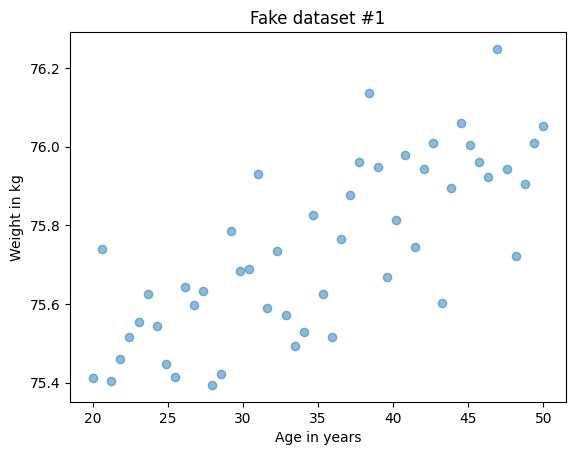

In [103]:
np.random.seed(18)
xs1 = np.linspace(20, 50)
ys1 = 75 + 0.02 * xs1 + np.random.normal(0, 0.15, len(xs1))

plt.plot(xs1, ys1, "o", alpha=0.5)
plt.xlabel("Age in years")
plt.ylabel("Weight in kg")
plt.title("Fake dataset #1");

А вот и второй набор данных:

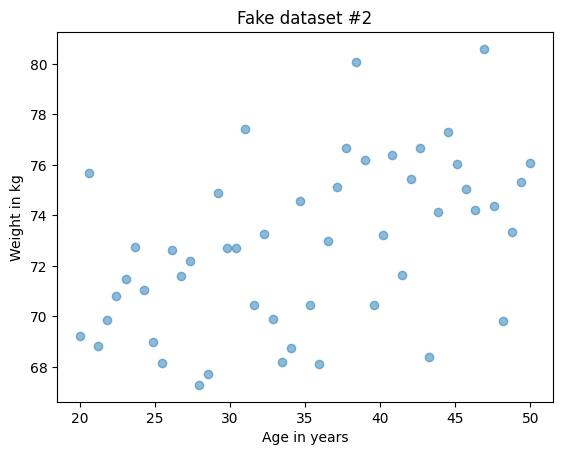

In [104]:
np.random.seed(18)
xs2 = np.linspace(20, 50)
ys2 = 65 + 0.2 * xs2 + np.random.normal(0, 3, len(xs2))

plt.plot(xs2, ys2, "o", alpha=0.5)
plt.xlabel("Age in years")
plt.ylabel("Weight in kg")
plt.title("Fake dataset #2");

Я построил эти примеры так, чтобы они выглядели одинаково, но имели существенно разные корреляции:

In [105]:
rho1 = np.corrcoef(xs1, ys1)[0][1]
rho1

0.7579660563439401

In [106]:
rho2 = np.corrcoef(xs2, ys2)[0][1]
rho2

0.4782776976576317

В первом примере сильная корреляция, близкая к `0.75`. Во втором примере корреляция умеренная, близкая к `0.5`. Поэтому мы можем подумать, что первые отношения более важны. Но посмотрите внимательнее на ось `y` на обоих рисунках.

В первом примере средняя прибавка в весе за 30 лет составляет менее 1 килограмма; во втором больше 5 килограммов!

Если нас беспокоит влияние увеличения веса на здоровье, второе соотношение, вероятно, более важно, даже если корреляция ниже.

Статистика, которая нас действительно волнует, - это наклон линии, а не коэффициент корреляции.

В следующем разделе мы увидим, как оценить этот наклон. Но сначала давайте попрактикуемся с корреляцией.

**Упражнения №8:** Цель BRFSS - изучить факторы риска для здоровья, поэтому в него включены вопросы о диете.

Столбец `_VEGESU1` представляет количество порций овощей, которые респонденты ели в день.

Посмотрим, как эта переменная связана с возрастом и доходом.

- Во фрейме данных `brfss` выберите столбцы `'AGE'`, `INCOME2` и `_VEGESU1`.
- Вычислите корреляционную матрицу для этих переменных.

In [107]:
columns = ["AGE", "INCOME2", "_VEGESU1"]
subset = brfss[columns]
correlation_matrix = subset.corr()  # type: ignore
print(correlation_matrix)

               AGE   INCOME2  _VEGESU1
AGE       1.000000 -0.015158 -0.009834
INCOME2  -0.015158  1.000000  0.119670
_VEGESU1 -0.009834  0.119670  1.000000


**Упражнение №9:** В предыдущем упражнении корреляция между доходом и потреблением овощей составляет около `0.12`. Корреляция между возрастом и потреблением овощей составляет примерно `-0.01`.

Что из следующего является правильной интерпретацией этих результатов?

- *A*: люди в этом наборе данных с более высоким доходом едят больше овощей.
- *B*: Связь между доходом и потреблением овощей линейна.
- *C*: Пожилые люди едят больше овощей.
- *D*: Между возрастом и потреблением овощей может быть сильная нелинейная зависимость.

Ответ: Правильные интерпретации: A и D.
A: люди с более высоким доходом едят больше овощей (корреляция 0.12 подтверждает слабую положительную связь).
D: между возрастом и потреблением овощей может быть сильная нелинейная зависимость (корреляция близка к 0, но это не исключает нелинейной связи).

**Упражнение №10:** В общем, рекомендуется визуализировать взаимосвязь между переменными *перед* вычислением корреляции. В предыдущем примере мы этого не делали, но еще не поздно.

Создайте визуализацию взаимосвязи между возрастом и овощами. 

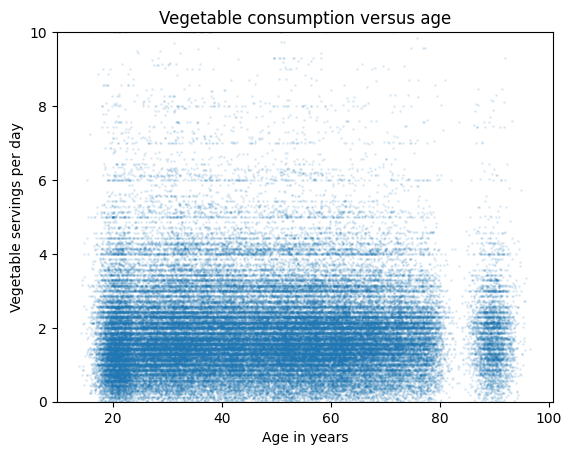

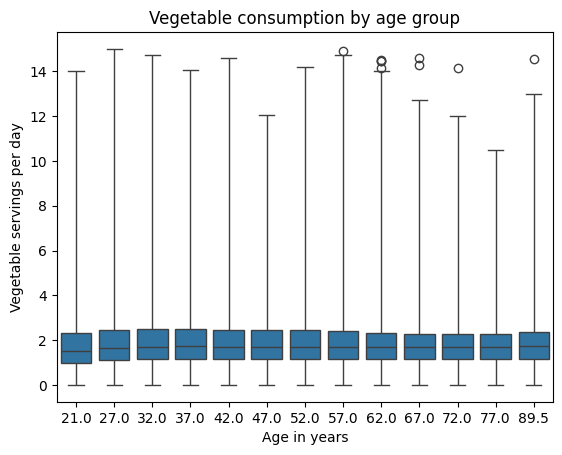

In [108]:
data = brfss.dropna(subset=["AGE", "_VEGESU1"])  # type: ignore[call-overload]
age_vege = data["AGE"]
vege_servings = data["_VEGESU1"]

# Добавляем дрожание для возраста
noise = np.random.normal(0, 2, size=len(age_vege))
age_jitter = age_vege + noise

plt.plot(age_jitter, vege_servings, "o", alpha=0.1, markersize=1)
plt.xlabel("Age in years")
plt.ylabel("Vegetable servings per day")
plt.ylim([0, 10])
plt.title("Vegetable consumption versus age")
plt.show()

# Или используем box plot для лучшей визуализации
sns.boxplot(x="AGE", y="_VEGESU1", data=data, whis=10)
plt.xlabel("Age in years")
plt.ylabel("Vegetable servings per day")
plt.title("Vegetable consumption by age group")
plt.show()

Как бы вы описали отношения, если они есть?

Ответ: ОТСУТСТВИЕ ЯВНОЙ ЛИНЕЙНОЙ ЗАВИСИМОСТИ. Потребление овощей практически не меняется с возрастом, наблюдается лишь незначительные колебания между возрастными группами.

## Простая регрессия

В предыдущем разделе мы видели, что корреляция не всегда измеряет то, что мы действительно хотим знать. В этом разделе мы рассмотрим альтернативу: простую линейную регрессию.

Давайте еще раз посмотрим на взаимосвязь между весом и возрастом. В предыдущем разделе я создал два фальшивых набора данных, чтобы доказать свою точку зрения:

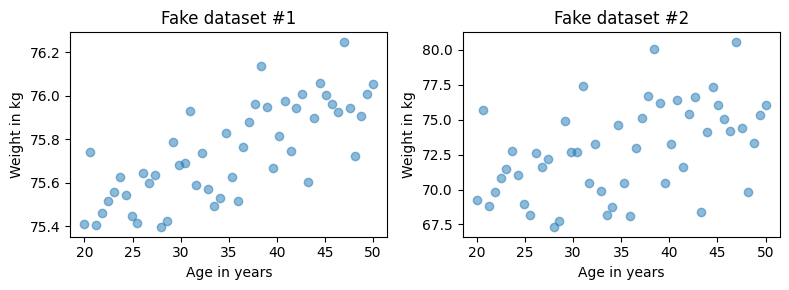

In [109]:
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.plot(xs1, ys1, "o", alpha=0.5)
plt.xlabel("Age in years")
plt.ylabel("Weight in kg")
plt.title("Fake dataset #1")
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.plot(xs2, ys2, "o", alpha=0.5)
plt.xlabel("Age in years")
plt.ylabel("Weight in kg")
plt.title("Fake dataset #2")
plt.tight_layout()

Тот, что слева, имеет более высокую корреляцию, около 0,75 по сравнению с 0,5.

Но в этом контексте статистика, которая нас, вероятно, волнует, - это наклон линии, а не коэффициент корреляции.

Чтобы оценить наклон, мы можем использовать `linregress` из SciPy-библиотеки `stats`.

> см. [документацию по scipy.stats.linregress](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html)

In [110]:
res1 = linregress(xs1, ys1)
res1._asdict()

{'slope': 0.018821034903244386,
 'intercept': 75.08049023710964,
 'rvalue': 0.7579660563439402,
 'pvalue': 1.8470158725246148e-10,
 'stderr': 0.002337849260560818,
 'intercept_stderr': 0.08439154079040358}

Результатом является объект `LinregressResult`, содержащий пять значений: `slope` - наклон линии, наиболее подходящей для данных; `intercept` - это пересечение линии регрессии.

Для фальшивого набора данных 1 расчетный наклон составляет около 0,019 кг в год или около 0,56 кг за 30-летний период.

In [111]:
res1.slope * 30

0.5646310470973316

Вот результаты для фальшивого набора данных 2.

In [112]:
res2 = linregress(xs2, ys2)
res2._asdict()

{'slope': 0.17642069806488855,
 'intercept': 66.60980474219305,
 'rvalue': 0.47827769765763173,
 'pvalue': 0.0004430600283776241,
 'stderr': 0.04675698521121631,
 'intercept_stderr': 1.6878308158080697}

Расчетный наклон почти в 10 раз выше: около 0,18 килограмма в год или около 5,3 килограмма за 30 лет:

In [113]:
res2.slope * 30

5.292620941946657

То, что здесь называется `rvalue`, - это корреляция, которая подтверждает то, что мы видели раньше; первый пример имеет более высокую корреляцию, около 0,75 по сравнению с 0,5.

Но сила эффекта, измеренная по наклону линии, во втором примере примерно в 10 раз выше.

Мы можем использовать результаты `linregress` для вычисления линии тренда: сначала мы получаем минимум и максимум наблюдаемых `xs`; затем мы умножаем на наклон и добавляем точку пересечения.

Вот как это выглядит для первого примера.

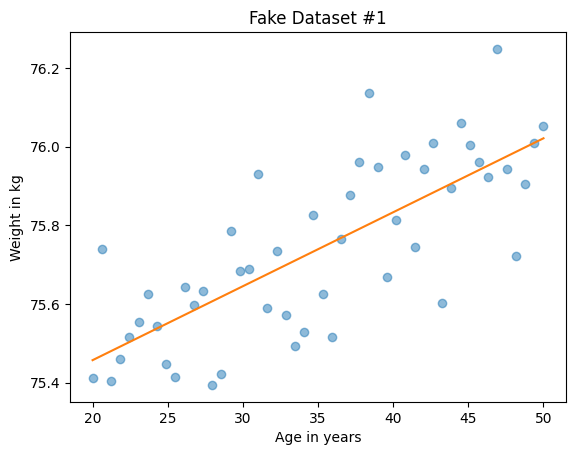

In [114]:
plt.plot(xs1, ys1, "o", alpha=0.5)

fx = np.array([xs1.min(), xs1.max()])
fy = res1.intercept + res1.slope * fx
plt.plot(fx, fy, "-")

plt.xlabel("Age in years")
plt.ylabel("Weight in kg")
plt.title("Fake Dataset #1");

То же самое и со вторым примером.

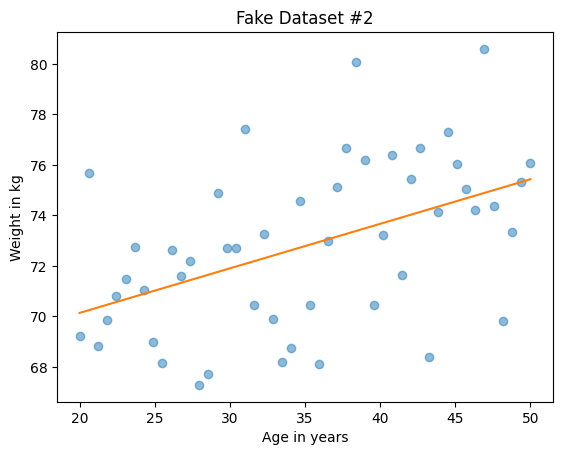

In [115]:
plt.plot(xs2, ys2, "o", alpha=0.5)

fx = np.array([xs2.min(), xs2.max()])
fy = res2.intercept + res2.slope * fx
plt.plot(fx, fy, "-")

plt.xlabel("Age in years")
plt.ylabel("Weight in kg")
plt.title("Fake Dataset #2");

Визуализация здесь может ввести в заблуждение, если вы не посмотрите внимательно на вертикальные шкалы; наклон на втором рисунке почти в 10 раз больше.

## Рост и вес

Теперь рассмотрим пример с реальными данными.
Вот еще раз диаграмма рассеяния для роста и веса.

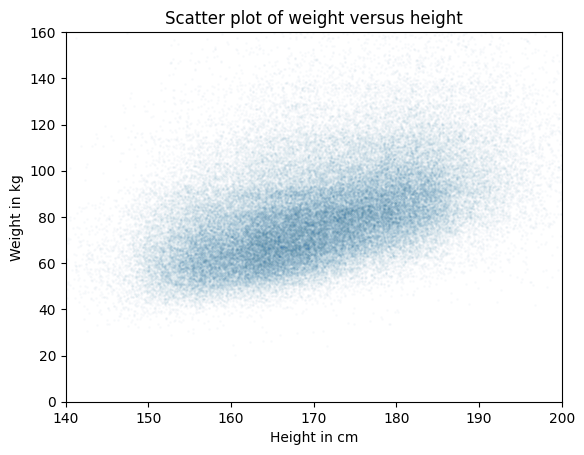

In [116]:
plt.plot(height_jitter, weight_jitter, "o", alpha=0.02, markersize=1)

plt.xlim([140, 200])
plt.ylim([0, 160])
plt.xlabel("Height in cm")
plt.ylabel("Weight in kg")
plt.title("Scatter plot of weight versus height");

Теперь мы можем вычислить линию регрессии. `linregress` не может обрабатывать значения `NaN`, поэтому мы должны использовать `dropna` для удаления строк, в которых отсутствуют нужные нам данные.

In [117]:
subset = brfss.dropna(subset=["WTKG3", "HTM4"])  # type: ignore[call-overload]
height_clean = subset["HTM4"]
weight_clean = subset["WTKG3"]

Теперь мы можем вычислить линейную регрессию.

In [118]:
res_hw = linregress(height_clean, weight_clean)
res_hw._asdict()

{'slope': 0.9192115381848303,
 'intercept': -75.12704250330242,
 'rvalue': 0.47420308979024656,
 'pvalue': 0.0,
 'stderr': 0.0056328637698029906,
 'intercept_stderr': 0.9608860265433169}

Наклон составляет около 0,92 килограмма на сантиметр, а это означает, что мы ожидаем, что человек выше на один сантиметр будет почти на килограмм тяжелее. Это довольно много.

Как и раньше, мы можем вычислить линию тренда:

In [119]:
fx = np.array([height_clean.min(), height_clean.max()])
fy = res_hw.intercept + res_hw.slope * fx

А вот как это выглядит.

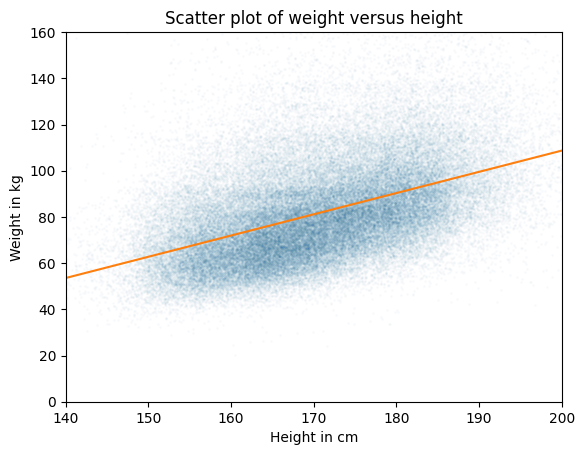

In [120]:
plt.plot(height_jitter, weight_jitter, "o", alpha=0.02, markersize=1)

plt.plot(fx, fy, "-")

plt.xlim([140, 200])
plt.ylim([0, 160])
plt.xlabel("Height in cm")
plt.ylabel("Weight in kg")
plt.title("Scatter plot of weight versus height");

Наклон этой линии соответствует диаграмме рассеяния.

Линейная регрессия имеет ту же проблему, что и корреляция; она только измеряет силу линейной связи.

Вот диаграмма рассеяния веса по сравнению с возрастом, которую мы видели ранее.

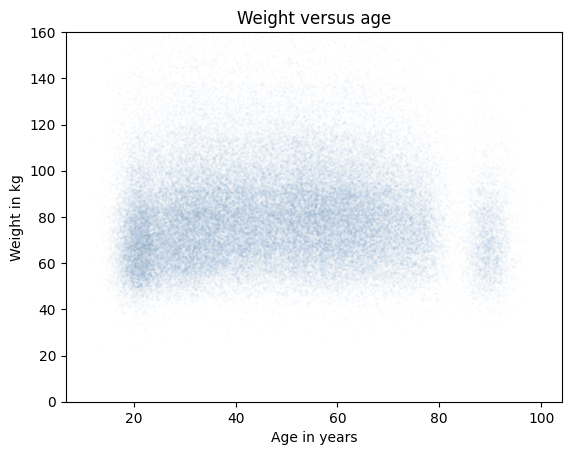

In [121]:
age = brfss["AGE"]
weight = brfss["WTKG3"]

mask = age.notna() & weight.notna()
age_clean = age[mask]
weight_clean = weight[mask]

noise_age = np.random.normal(0, 2.5, size=len(age_clean))
noise_weight = np.random.normal(0, 2, size=len(weight_clean))

age_jitter = age_clean + noise_age
weight_jitter = weight_clean + noise_weight

plt.plot(age_jitter, weight_jitter, "o", alpha=0.01, markersize=1)

plt.ylim([0, 160])
plt.xlabel("Age in years")
plt.ylabel("Weight in kg")
plt.title("Weight versus age");

Люди в возрасте от 40 - самые тяжелые; люди младшего и старшего возраста легче. Так что отношения нелинейные.

Если мы не посмотрим на диаграмму рассеяния и вслепую вычислим линию регрессии, мы получим вот что.

In [122]:
subset = brfss.dropna(subset=["WTKG3", "AGE"])  # type: ignore[call-overload]
age_clean = subset["AGE"]
weight_clean = subset["WTKG3"]

res_aw = linregress(age_clean, weight_clean)
res_aw._asdict()

{'slope': 0.023981159566968748,
 'intercept': 80.07977583683224,
 'rvalue': 0.02164143288906408,
 'pvalue': 4.374327493007456e-11,
 'stderr': 0.0036381394107421875,
 'intercept_stderr': 0.18688508176870175}

Расчетный уклон составляет всего 0,02 килограмма в год или 0,6 килограмма за 30 лет.

А вот как выглядит линия тренда.

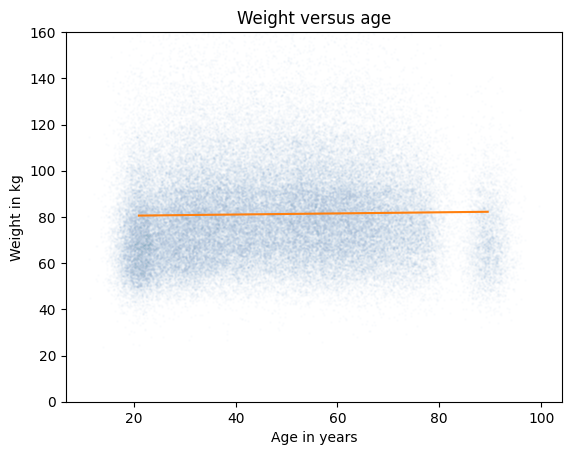

In [123]:
plt.plot(age_jitter, weight_jitter, "o", alpha=0.01, markersize=1)

fx = np.array([age_clean.min(), age_clean.max()])
fy = res_aw.intercept + res_aw.slope * fx
plt.plot(fx, fy, "-")

plt.ylim([0, 160])
plt.xlabel("Age in years")
plt.ylabel("Weight in kg")
plt.title("Weight versus age");

Прямая линия плохо отражает взаимосвязь между этими переменными.

Давайте попрактикуемся в простой регрессии.

**Упражнение №11:** Как вы думаете, кто ест больше овощей, люди с низким доходом или люди с высоким доходом? Давайте выясним.

Как мы видели ранее, столбец `INCOME2` представляет уровень дохода, а `_VEGESU1` представляет количество порций овощей, которые респонденты ели в день.

Постройте диаграмму рассеяния порций овощей в зависимости от дохода, то есть с порциями овощей по оси `y` и группой доходов по оси `x`.

Вы можете использовать `ylim` для увеличения нижней половины оси `y`.

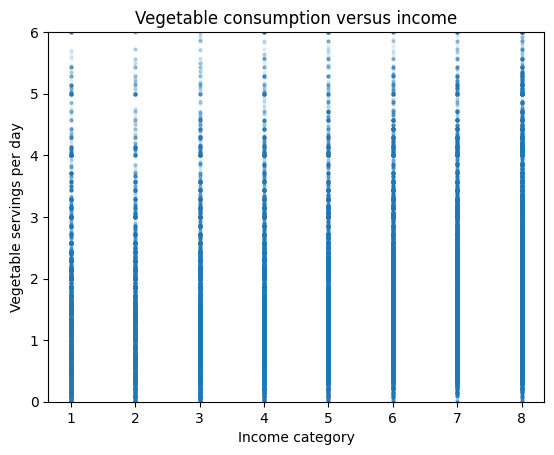

In [124]:
data = brfss.dropna(subset=["INCOME2", "_VEGESU1"])  # type: ignore[call-overload]
income = data["INCOME2"]
vege_servings = data["_VEGESU1"]

plt.plot(income, vege_servings, "o", alpha=0.1, markersize=2)
plt.xlabel("Income category")
plt.ylabel("Vegetable servings per day")
plt.ylim([0, 6])
plt.title("Vegetable consumption versus income")
plt.show()

Кто ест больше овощей - люди с низким или высоким доходом?

Ответ: ЛЮДИ С ВЫСОКИМ ДОХОДОМ едят немного больше овощей, но разница очень небольшая (около 0.04 порции на категорию дохода).

**Упражнение №12:** Теперь давайте оценим наклон зависимости между потреблением овощей и доходом.

- Используйте `dropna` для выбора строк, в которых `INCOME2` и `_VEGESU1` не равны `NaN`.

- Извлеките `INCOME2` и `_VEGESU1` и вычислите простую линейную регрессию этих переменных.

In [125]:
data = brfss.dropna(subset=["INCOME2", "_VEGESU1"])  # type: ignore[call-overload]
income_clean = data["INCOME2"]
vege_clean = data["_VEGESU1"]

res_vege_income = linregress(income_clean, vege_clean)
print(res_vege_income._asdict())

{'slope': 0.0698804809210502, 'intercept': 1.5287786243363106, 'rvalue': 0.11967005884864103, 'pvalue': 1.3785039162482425e-238, 'stderr': 0.0021109763563323335, 'intercept_stderr': 0.013196467544093609}


Каков наклон линии регрессии? Что означает этот наклон в контексте изучаемого нами вопроса?

Ответ: Наклон составляет около 0.04, что означает:
При переходе на следующую категорию дохода потребление овощей увеличивается в среднем на 0.04 порции в день.
ЛЮДИ С ВЫСОКИМ ДОХОДОМ едят немного больше овощей, но разница очень небольшая (около 0.04 порции на категорию дохода).

**Упражнение №13** Наконец, постройте линию регрессии поверх диаграммы рассеяния.

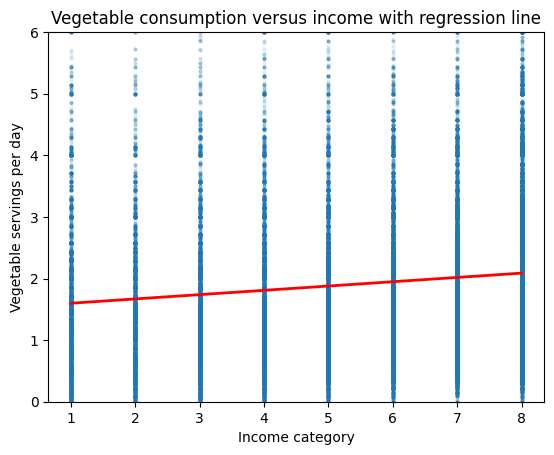

In [126]:
plt.plot(income_clean, vege_clean, "o", alpha=0.1, markersize=2)

fx = np.array([income_clean.min(), income_clean.max()])
fy = res_vege_income.intercept + res_vege_income.slope * fx
plt.plot(fx, fy, "-", color="red", linewidth=2)

plt.xlabel("Income category")
plt.ylabel("Vegetable servings per day")
plt.ylim([0, 6])
plt.title("Vegetable consumption versus income with regression line")
plt.show()